In [1]:
#pip install reportlab
import json
import glob
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import itertools
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
with open('dataset.json', 'r') as file:
    data = json.load(file)

print(data)

In [ ]:
len(data)

In [4]:
# extract images of one restaurant
one_restaurant_info=data[0]['more_details']['full_images']
one_restaurant_images=[i['image_id'] for i in one_restaurant_info]
one_restaurant_images

['2088757', '2182000', '4151606', '4151588', '2224983']

In [5]:
# do this for all restaurants

res_image_dic={}
for res in data:
    res_id=res['identifier']
    one_restaurant_info=res['more_details']['full_images']
    one_restaurant_images=[i['image_id'] for i in one_restaurant_info]
    res_image_dic[res_id]=one_restaurant_images

In [6]:
# check if restaurant ids are unique
len(list(res_image_dic.keys()))== len(set(res_image_dic.keys()))

True

In [7]:
# list of all restaurant images
nested_list=list(res_image_dic.values())
image_names = list(itertools.chain(*nested_list))
#image_names

In [ ]:
# test reading an image
folder_path = 'images'
image_path=folder_path + '/' + '4151606' + '.jpg'
img=Image.open(image_path)
img

In [9]:
# reading all images in a restaurant setting 
all_images={}
folder_path = 'images'
target_size = (256, 256) # need to resize because some images do not have the same shap

iteration=0 # read only 100 images for now
for name in image_names:
    iteration+=1
    file_name=name + '.jpg'
    image_path = folder_path + '/' + file_name
    if iteration <=100:
        try:
            with Image.open(image_path) as img:
                img = img.resize(target_size)
                image_array = np.array(img)

                all_images[name]=image_array
            #print(name)
        except:
            print(f"Error opening file '{file_name}', skipping...")
            continue

In [ ]:
# plot one image based on id
plt.imshow(all_images['2182000'], cmap='gray')
plt.show()

# use 20 manual labels

In [11]:
selected_ids=(list(all_images.keys()))
label_ids=selected_ids[:20] # should change to random select just in case there is corr
no_label_ids=selected_ids[20:]

train_image_list=[]
for i in label_ids: # show images in order to label them 
    #plt.imshow(all_images[i], cmap='gray')
    #plt.show()
    train_image_list.append(all_images[i])
    #print(all_images[i].shape) 

In [12]:
test_image_list=[]
for i in no_label_ids: 
    test_image_list.append(all_images[i])
   # print(all_images[i].shape) 

In [13]:
# use 0 for food, 1 for interiror
label_ids = [1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
len(label_ids)

20

In [14]:
sum(label_ids) # there is a slight imbalance

12

In [15]:
train=np.array(train_image_list)
train.shape

(20, 256, 256, 3)

In [16]:
test=np.array(test_image_list)
test.shape

(80, 256, 256, 3)

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.applications import VGG16

# Load the pre-trained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze pre-trained layers (compare with no freezing)
for layer in base_model.layers:
    layer.trainable = False

# Define your own classification layers
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [43]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.applications import VGG19

# Load the pre-trained model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze pre-trained layers (compare with no freezing)
for layer in base_model.layers:
    layer.trainable = False

# Define your own classification layers
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

80134624/80134624 [==============================] - 6s 0us/step


In [72]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten
from tensorflow.keras.applications.resnet50 import ResNet50

# Load the pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze pre-trained layers (compare with no freezing)
for layer in base_model.layers:
    layer.trainable = False

# Define your own classification layers
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [73]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_5 (Flatten)         (None, 131072)            0         
                                                                 
 dense_10 (Dense)            (None, 128)               16777344  
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 40,365,185
Trainable params: 16,777,473
Non-trainable params: 23,587,712
_________________________________________________________________


In [74]:
# Load your own training and test data (new result if freeze previous layers)
train_images = train[:10]
train_labels = np.array(label_ids[:10])
test_images = train[10:]
test_labels = np.array(label_ids[10:])

# Train the model
model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_data=(test_images, test_labels))

# Evaluate the model on test set
score = model.evaluate(test_images, test_labels)
print('Test accuracy:', score[1])

Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.5309 - accuracy: 0.7000 - val_loss: 1.8314e-04 - val_accuracy: 1.0000
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 3.8523e-05 - val_accuracy: 1.0000
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 8.7384e-06 - val_accuracy: 1.0000
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 2.7996e-06 - val_accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 1.0831e-06 - val_accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 4.7654e-07 - val_accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 2.3222e-07 - val_accura

In [75]:
# look at the test images without labels, check if predicted correctly
new_images = test[:40]

In [76]:
# Predict new images with the model
model_predictions=model.predict(new_images)
# set the threshold
threshold = 0.5
# convert predicted probabilities to labels 0 and 1
predicted_labels = (model_predictions > threshold).astype(int)
# print the predicted labels

2/2 [==============================] - 3s 525ms/step


In [77]:
convert_label_dict={0: 'food', 1: 'exterior'}

In [78]:
 # show images in order to check prediction 
#for ind, item in enumerate(new_images):
#    label=predicted_labels[ind][0]
#    print('image ' + str(ind) + ' label:' + (convert_label_dict[label]))
#    plt.imshow(item, cmap='gray')
#    plt.show()

In [79]:
def save_image(filename):
    p = PdfPages(filename)
    for ind, item in enumerate(new_images): # show images in order to check prediction 
        label=predicted_labels[ind][0]
        fig= plt.figure()
        plt.imshow(item, cmap='gray')
        plt.title('image ' + str(ind) + ' label:' + (convert_label_dict[label]))
        fig.savefig(p, format='pdf') 
    # close the object
    p.close()  

In [80]:
# name Pdf file
# filename = "multi_plot_image.pdf"  
# save_image(filename)  

# use more manual labels

In [ ]:
# path to the folder containing the JSON files
folder_path = 'images_labelled/'
# get a list of all the files in the folder
file_list = os.listdir(folder_path)

label_dict={}
# iterate over the files
for file_name in file_list:
    # check if the file is a JSON file
    if file_name.endswith('.json'):
        # construct the full path to the file
        file_path = os.path.join(folder_path, file_name)
        # open the file and read its contents
        with open(file_path, 'r') as file:
            json_data = json.load(file)        
        txt=json_data['imagePath']
        image_id=txt.split(".")[0]
        label_dict[image_id]=int(json_data['flags']['restaurant'])
        print(json_data)

In [82]:
# just use the previous model to predict and see the outcome

image_names_test=list(label_dict.keys())
image_labels_test=list(label_dict.values())

In [83]:
# reading all images in a restaurant setting 
#all_test_images={}
folder_path = 'images'
target_size = (256, 256) # need to resize because some images do not have the same shap

# read all
test_label=[]
new_test_image_list= []
for ind,name in enumerate(image_names_test):
    file_name=name + '.jpg'
    image_path = folder_path + '/' + file_name
    try:
        with Image.open(image_path) as img:
            img = img.resize(target_size)
            image_array = np.array(img)
            #all_test_images[name]=image_array       
            new_test_image_list.append(image_array)
            test_label.append(image_labels_test[ind])
            #print(name)
    except:
        print(f"Error opening file '{file_name}', skipping...")
        continue

In [84]:
print('read ' + str(len(new_test_image_list)) + ' images')

read 535 images


In [85]:
sum(test_label)/len(test_label)
# there is a slight issue of class imbalance, accuracy is not be the best metric

0.33457943925233646

In [86]:
new_test=np.array(new_test_image_list)
new_test.shape

(535, 256, 256, 3)

In [87]:
model_predictions_test=model.predict(new_test)
threshold = 0.5
predicted_labels_test = (model_predictions_test > threshold).astype(int)

17/17 [==============================] - 34s 2s/step


In [88]:
accuracy = accuracy_score(test_label, predicted_labels_test)
print(accuracy) 

0.9738317757009346


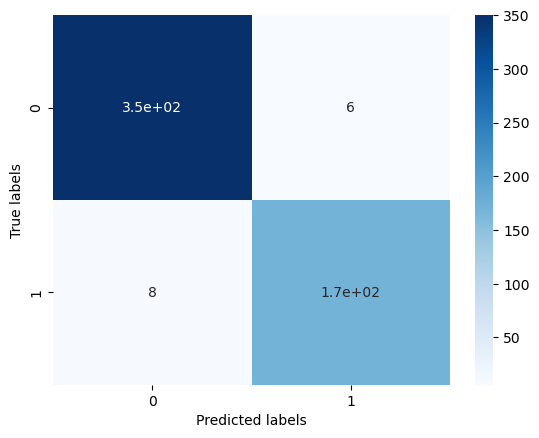

In [89]:
# Compute confusion matrix
cm = confusion_matrix(test_label, predicted_labels_test)

# Plot heatmap
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [90]:
#find misclassified images
def find_mismatch_pos(list1, list2):
    all_pos=[]
    for i in range(len(list1)):
        if list1[i] != list2[i]:
            all_pos.append(i)
    return all_pos # if no mismatch found

misclassified = find_mismatch_pos(test_label, predicted_labels_test)

In [91]:
convert_label_dict={0: 'food', 1: 'exterior'}

In [ ]:
# almost all (but one) classify exterior as food
for ind, item in enumerate(misclassified):
    predict_label=predicted_labels_test[item][0]
    actual_label=test_label[item]
    print('image ' + str(ind) + ' actual label:' + (convert_label_dict[actual_label]))
    print('image ' + str(ind) + ' predict label:' + (convert_label_dict[predict_label]))
    plt.imshow(new_test[item], cmap='gray')
    plt.show()

In [93]:
# to-do: add interpretability technique to explain the model